In [7]:
# need a training dataset of simulated X_i = (T_i,Cv_i) data and the corresponding spectrum vectors s_j

import numpy as np
from matplotlib import pyplot as plt

In [32]:
# makeT produces a vector of sorted, log-uniform distributed temperatures in the range [Tmin,Tmax]

def makeT(m, Tmin, Tmax):
    logTmax = np.log(Tmax)
    logTmin = np.log(Tmin)
    return np.sort(np.exp(np.random.uniform(logTmin, logTmax, m)))


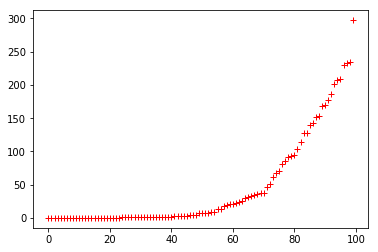

In [39]:
plt.plot(makeT(100,0.1,300),'r+')

In [94]:
# here I work on modelling the density of states

# makeW returns a vector of n omega (energy) values, up to wmax
def makeW(n, wmax):
    return (np.linspace(0, wmax, n),wmax/(n-1.))

# debyeMode is normalized to 1, and takes the Debye frequency as a parameter
# logical test implements the cutoff for w > wD
def debyeSpectrum(w,wD):
    return (w<=wD)*3*w*w/(wD*wD*wD)

# opticalMode is also normalized to 1
# models an optical phonon mode as a higher frequency Gaussian with mean mu and width sig
def opticalMode(w, wbar, sig):
    return np.exp(-0.5*(w-wbar)*(w-wbar)/(sig*sig))/np.sqrt(2*np.pi*sig*sig)


1.002254633765022


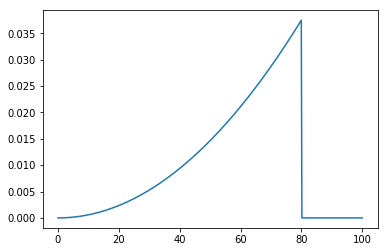

In [103]:
(w,dw) = makeW(500,100)
dos = debyeSpectrum(w, 80)
# check normalization, should be ~1 (very poor integration approximation)
print np.sum(dos*dw)
# plot
plt.plot(w,dos)

In [109]:
dos = opticalMode(w,[50,60],[10,5])

# check normalization, should be ~1 (very poor integration approximation)
#print np.sum(dos*dw)
# plot
#plt.plot(w,dos)

ValueError: operands could not be broadcast together with shapes (500,) (2,) 